<img src="static/img/rosslog.png" align="left">  

# Rossmann Stores Predictions

This notebook covers basics of data cleaning, EDA, feature engineering, and data modelling. For more in-deph data analysis, please consider Kaggle Kernels: https://www.kaggle.com/c/rossmann-store-sales/kernels

**IMPORTANT: Make sure you do not skip any cells. In that case you risk not being able to accomplish given tasks.** 


## Rossmann Data Cleaning 

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. In this first part of the notebook we will walk you through basic steps that need to be done before start with baseline modelling.

### Load libraries and data

In [2]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
from pandas import DataFrame
from pandas import Grouper

# Matplotlib for visualization
from matplotlib import pyplot as plt

# Display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

In [3]:
# Load data from CSV
train_dataset = pd.read_csv("static/data/train.csv")
stores = pd.read_csv("static/data/store.csv")

train_dataset.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


The train data set contains sales by day for each store with the following columns:

- Store - a unique id number
- DayOfWeek/Date - the day of the week (1-7) and date (YYYY-MM-DD) for a sales data point
- Sales - the sales for a given day
- Customers - the number of customers on a given day. This column is highly correlated with sales and is not present in the test set.
- Open - Values: 0 = closed, 1 = open
- Promo - indicates whether a store was running a sales promotion that day
- StateHoliday - Values: a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if a store was affected by the closure of public schools on that day

###### Question 1

In [4]:
# YOUR CODE GOES HERE
# Print first five rows of the "stores" dataset

stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


The stores data set contains additional columns about each store that does not vary by day:

- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes the level of products available: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor
- CompetitionOpenSince[Month/Year] - month/year when the nearest competitor was opened
- Promo2 - indicator for a recurring promotion: 0 = store not participating, 1 = participating
- Promo2Since[Week/Year] - calendar week/year when the store started participating in Promo2
- PromoInterval - describes the intervals when Promo2 is started. E.g. "Feb,May,Aug,Nov" means each round starts in those months of any given year for that store

###### Question 2

In [5]:
# YOUR CODE GOES HERE
# Check out the shape of the datasets. 
# We have a lot of data observations to play around.

print(train_dataset.shape)
print(stores.shape)

(1017209, 9)
(1115, 10)


Take a look and understand different data types.

In [6]:
# Column datatypes
print(train_dataset.dtypes,'\n')
print(stores.dtypes)

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object 

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


### Drop unwanted observations

Our goal during the data cleaning phase is to fix any problems with the provided data sets, such as:

- Fix inconsistent data
- Replace missing data with reasonable values
- Remove Data that cannot be fixed
- Convert categorical variables to numeric values
- Check for outlying values, and correct them if necessary

We needed to fix these types of problems so that our prediction models could be fit as accurately as possible.

In [7]:
# Check for duplicates
train_dataset = train_dataset.drop_duplicates()
stores = stores.drop_duplicates()

# Print shape after removing duplicates
train_dataset.shape, stores.shape

((1017209, 9), (1115, 10))

There were no duplicates. Now, let us check closed stores, stores with no customers, and stores where sales values equals zero.

In [8]:
# Drop closed observation
train_dataset = train_dataset[train_dataset.Open != 0]
train_dataset.shape

(844392, 9)

###### Question 3

In [9]:
# YOUR CODE GOES HERE
# Print the number of stores where Customers=0

train_dataset.loc[train_dataset['Customers']==0,'Store'].nunique()

40

In [10]:
train_dataset[train_dataset.Customers == 0].sort_values(by=['Store']).head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
561199,25,4,2014-02-13,0,0,1,0,0,0
562314,25,3,2014-02-12,0,0,1,0,0,0
348604,28,2,2014-09-02,0,0,1,1,0,1
347669,28,3,2014-09-03,0,0,1,1,0,1
346734,28,4,2014-09-04,0,0,1,1,0,0


###### Question 4

In [11]:
# YOUR CODE GOES HERE
# Print the number of stores where Sales=0

train_dataset.loc[train_dataset['Sales']==0,'Store'].nunique()

41

After checking the data, we decide to drop Sales == 0 observations:

In [12]:
train_dataset = train_dataset[train_dataset.Sales != 0]

In [13]:
train_dataset.shape

(844338, 9)

### Feature engineering

We are going to create new feature called "AvgPurchasing" we will use in the second section of this notebook. Than, we summarize numerical features to understand our data better.

In [14]:
train_dataset['AvgPurchasing'] = train_dataset.Sales / train_dataset.Customers

In [15]:
# Summarize numerical features
train_dataset.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,AvgPurchasing
count,844338.000000,844338.000000,844338.000000,844338.000000,844338.0,844338.000000,844338.000000,844338.000000
mean,558.421374,3.520350,6955.959134,762.777166,1.0,0.446356,0.193578,9.493641
std,321.730861,1.723712,3103.815515,401.194153,0.0,0.497114,0.395102,2.197448
min,1.000000,1.000000,46.000000,8.000000,1.0,0.000000,0.000000,2.749075
25%,280.000000,2.000000,4859.000000,519.000000,1.0,0.000000,0.000000,7.895571
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000,9.250000
75%,837.000000,5.000000,8360.000000,893.000000,1.0,1.000000,0.000000,10.899729
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000,64.957854


In [16]:
# Promo2Since[Year/Week] 
# Describes the year and calendar week 
# when the store started participating in Promo2

stores.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


### Missing values of numerical features

Let us check for missing values and fill in any add indicator variable for missing data

In [17]:
print(train_dataset.select_dtypes(exclude=['object']).isnull().sum(),'\n')
print(stores.select_dtypes(exclude=['object']).isnull().sum())

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
SchoolHoliday    0
AvgPurchasing    0
dtype: int64 

Store                          0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
dtype: int64


In [18]:
# For the competition data, check the 3 missing CompetitionDistance
stores[stores['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [19]:
# Fill and flag the missing numeric data

stores.CompetitionOpenSinceMonth.fillna(0, inplace=True)
stores.CompetitionOpenSinceYear.fillna(0, inplace=True)
stores.CompetitionDistance.fillna(0, inplace=True)

# Indicator variable for missing numeric data

stores['CompetitionOpenSinceMonth_missing'] = stores.CompetitionOpenSinceMonth.isnull().astype(int)
stores['CompetitionOpenSinceYear_missing'] = stores.CompetitionOpenSinceYear.isnull().astype(int)
stores['CompetitionDistance_missing'] = stores.CompetitionDistance.isnull().astype(int)

# Just fill the nan with 0 

stores.Promo2SinceWeek.fillna(0, inplace=True)
stores.Promo2SinceYear.fillna(0, inplace=True)
stores.PromoInterval.fillna(0, inplace=True)

In [20]:
stores.isnull().sum()

Store                                0
StoreType                            0
Assortment                           0
CompetitionDistance                  0
CompetitionOpenSinceMonth            0
CompetitionOpenSinceYear             0
Promo2                               0
Promo2SinceWeek                      0
Promo2SinceYear                      0
PromoInterval                        0
CompetitionOpenSinceMonth_missing    0
CompetitionOpenSinceYear_missing     0
CompetitionDistance_missing          0
dtype: int64

### Categorical features cleaning

Notice that we have two zero values: one integer and one string. Let us fix this and have one string zero value for all StateHoliday representations.

In [21]:
# Display unique values of 'basement'
train_dataset.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

###### Question 5

In [22]:
# YOUR CODE
# Your result should look like this: 
### array(['0', 'a', 'b', 'c'], dtype=object)

train_dataset = train_dataset.astype({"StateHoliday": str})
train_dataset.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

Check missing values for categorical variables

In [23]:
# Display number of missing values by categorical feature
print(train_dataset.select_dtypes(include=['object']).isnull().sum(), '\n')
print(stores.select_dtypes(include=['object']).isnull().sum())

Date            0
StateHoliday    0
dtype: int64 

StoreType        0
Assortment       0
PromoInterval    0
dtype: int64


### Joining the "Train" and "Store" tables 

Before joining our tables, we need to set both of our table indexes. Let us set the Store values as our new table indexes.

###### Question 6

In [24]:
# YOUR CODE
# Set index in train_dataset to correspond to the train_dataset['Store'] values
# Set index in stores to correspond to the stores['Store'] values
# Drop Store column in train_dataset

# train_dataset.set_index('Store', inplace=True)
# stores.set_index('Store', inplace=True)

In [25]:
# df_combined = train_dataset.join(stores)

# df_combined['Store'] = df_combined.index 
# Rebecca added this line above to recreate Store column that got lost in the join

# df_combined = df_combined.reset_index(drop=True)
# print(df_combined.shape)
# df_combined.head()

In [26]:
# use merge, rather than reseting indicies and using join

df_combined = train_dataset.merge(stores, left_on='Store', right_on='Store')
print(df_combined.shape)
df_combined.head()

(844338, 22)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,AvgPurchasing,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,9.194139,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,9.143403,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,8.948214,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,9.970588,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0


### Convert store type and assortment from char to int

StateHoliday, StoreType, and Assortment, needs to be transformed into one-hot-encoding after all the cleaning and feature engineering. Let us explore each of this features unique values and replace them with int values. For example:

1. StoreType ['a', 'b', 'c', 'd'] needs to be converted into [1, 2, 3, 4]
2. Assortment ['a', 'b', 'c'] needs to be converted into [1, 2, 3]
3. StateHoliday ['0', 'a', 'b', 'c'] needs to be converted into [0 ,1, 2, 3]

In [27]:
df_combined.StoreType.unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [28]:
df_combined.Assortment.unique()

array(['a', 'c', 'b'], dtype=object)

In [29]:
df_combined.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [30]:
df_combined.SchoolHoliday.unique()

array([1, 0])

###### Question 7

In [31]:
# YOUR CODE
# Transform into one-hot-encoding 

di = {"0": 0, "a": 1, "b": 2, "c": 3, "d": 4}
print(di)

df_combined['StoreType'] = df_combined['StoreType'].map(di)

df_combined['Assortment'] = df_combined['Assortment'].map(di)

df_combined['StateHoliday'] = df_combined['StateHoliday'].map(di)

# Result should look like: 

#### StoreType ['a', 'b', 'c', 'd'] needs to be converted into [1, 2, 3, 4]
#### Assortment ['a', 'b', 'c'] needs to be converted into [1, 2, 3]
#### StateHoliday ['0', 'a', 'b', 'c'] needs to be converted into [0 ,1, 2, 3]

{'0': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}


In [32]:
# Check out your previous code
print("StoreType: ", np.sort(df_combined.StoreType.unique()))
print("Assortment: ", np.sort(df_combined.Assortment.unique()))
print("StateHoliday: ", np.sort(df_combined.StateHoliday.unique()))

StoreType:  [1 2 3 4]
Assortment:  [1 2 3]
StateHoliday:  [0 1 2 3]


## EDA

To determine what type of models and predictors might work best for predicting sales, we studied which factors are causing the most variance in sales.

#### Variations based on Store Attributes

One of the biggest sources of variance in sales is based on the store number. In the graph below we show the average sales for the first ten stores in the data set. We can see that the average sales are quite different for each store and that there is no linear pattern. We do see stores with similar sales levels, suggesting the stores may fall into groups.

The scatterplot below that shows the average sales for all the stores. We can again see that some stores have similar levels of sales, so it's likely we can group stores together when making sales predictions, which is something for which tree models are well suited.

Each store number is effectively a category with its own particular sales level. When predicting future sales, we would like a single model that can make predictions for each store rather than having to fit a separate model for each store.

In [33]:
df_combined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,AvgPurchasing,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,9.194139,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,9.143403,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,8.948214,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,9.970588,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0


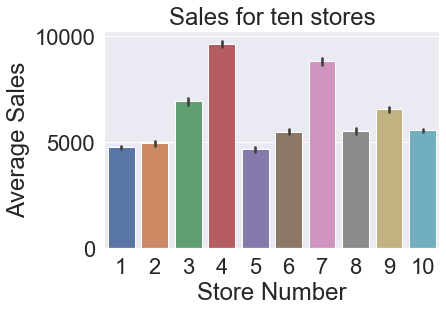

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


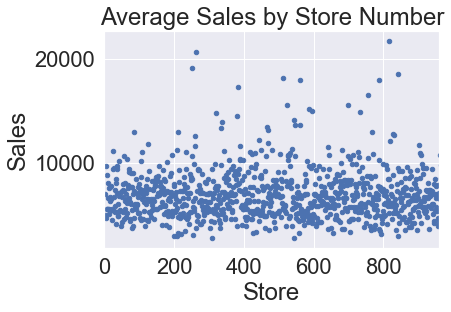

In [35]:
df_subset = df_combined[(df_combined['Store'] < 11)]

sns.set(font_scale=2)

# Plot store sales for stores 1 to 10
fig, ax = plt.subplots(1,1)

p3 = sns.barplot(x='Store', y='Sales', data=df_subset, ax=ax)
ax.set(xlabel='Store Number')
ax.set_ylabel('Average Sales')
ax.set_title('Sales for ten stores')

plt.show()

# Create a plot of average sales per store id
avg_sales_per_store = df_combined[['Sales', 'Store']].groupby('Store').mean()
avg_sales_per_store.reset_index().plot(kind='scatter', x='Store', y='Sales')
plt.xlim(0,960)
plt.title("Average Sales by Store Number")

plt.show()

The data set has categorical variables for different store types and the assortment of products for sale at each store. We see that these categories are a source of variance in sales.

#### Impact of Number of Customers

After exploration of the train and test sets, we ascertained that only the training data contains the number of Customers feature. The visualization below shows the positive correlation between the number of customers and sales (and also outliers). This feature is highly correlated with sales, but it’s not available until after the sales occur (i.e. it’s not in the test set). But exploring this feature helps make a case for including a proxy for the Customers feature in our final predictors (see the Feature Engineering section).

We also see that there’s added information with the behavior of customers per StoreType. We see that StoreType d (shown in green) that projects to the upper left quadrant. This means that for the same level of Sales, StoreType d requires fewer customers than StoreType b (blue). There’s less clarity of StoreType impact in the middle of the cone shaped scatter, but we can certainly see the impact of Customers and Sales conditional on the StoreType mostly in the outer regions of the visualization. Thus StoreType is a relevant feature, but as a function of Customers, as we can see that around 2000 to 3000 Customers there’s a break in the cluster pattern of the middle section of the cone. Therefore, further substantiation for us to include a proxy of the Customers feature in the model.

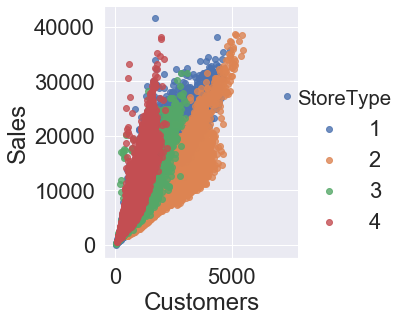

In [36]:
sns.lmplot(x='Customers', y='Sales', data=df_combined, hue='StoreType',fit_reg=False)

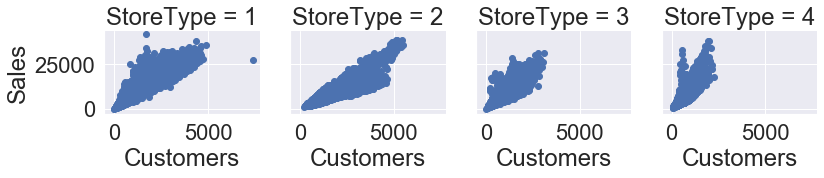

In [37]:
g = sns.FacetGrid(df_combined, col="StoreType")
g.map(plt.scatter, "Customers", "Sales")

## Rossmann Data Modeling

Due to the regressive predictive nature of The Rossmann Project, we decided to approach our model methodology with a Linear Regression base model with feature selection. Note: you can also consider Ridge regression to evaluate the effects of regularization on the predictive performance. 

*Note: The time dimension has a tremendous impact in this project. The Kaggle competition consisted in predicted the next 6 weeks (or 42 days), our splitting lead to have a testing set very large of over 900 days, explaining the fast degradation of the explained variance. These issues are the same the world of finance and economics are facing. For example the usage of an AR(n) to predict future outcomes quickly converge to a stationary states. In a real world, one would adjust the model based on the observed error. This is the spirit of tools such as the 'Kalman Filter' that are usually implemented in these domains.* 

*One other potential approach would consist in implementing more complicated model that naturally combine time series and decision tree, such as ART (Autoregressive Trees). The proposed method are outside of the scope of this course and thus we will focus on some other tehniques here.*

### Linear Regression

For our first baseline model, we decided to use linear regression. We used one hot encoding to convert categorical values into indicator columns. The store number is effectively a category with over 1000 different categories. We know that sales is not linear with the arbitrary numbers assigned to stores, so if this were our final model, it might have been reasonable to fit a separate regression model for each store. But since this is a baseline model, we treated the high dimension categories as if they were numeric values.

In the next section we will explore how different features affect overall score. You will be challenged to spot the differences and explain what given results mean.

In [38]:
# drop Store column
# it's a label; we do not want it going into the model as a predictor

df_combined = df_combined.drop(['Store'], axis=1)

print(df_combined.shape)
df_combined.head()

(844338, 21)


,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,AvgPurchasing,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
0,5,2015-07-31,5263,555,1,1,0,1,9.482883,3,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0
1,4,2015-07-30,5020,546,1,1,0,1,9.194139,3,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0
2,3,2015-07-29,4782,523,1,1,0,1,9.143403,3,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0
3,2,2015-07-28,5011,560,1,1,0,1,8.948214,3,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0
4,1,2015-07-27,6102,612,1,1,0,1,9.970588,3,...,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0


#### Load libraries

In [39]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Let us drop some temporal features given that we are not performing time-series analysis.

In [40]:
#drop PromoInterval (includes Mar,Jun,Sept,Dec)
#drop Date -> no time-series prediction

no_Promo_Date = df_combined.drop(['PromoInterval', 'Date'], axis=1)

# create target (Sales) variable 
target = no_Promo_Date['Sales']

#### Linear Regression: *ver. 1*

R2 score: 0.76


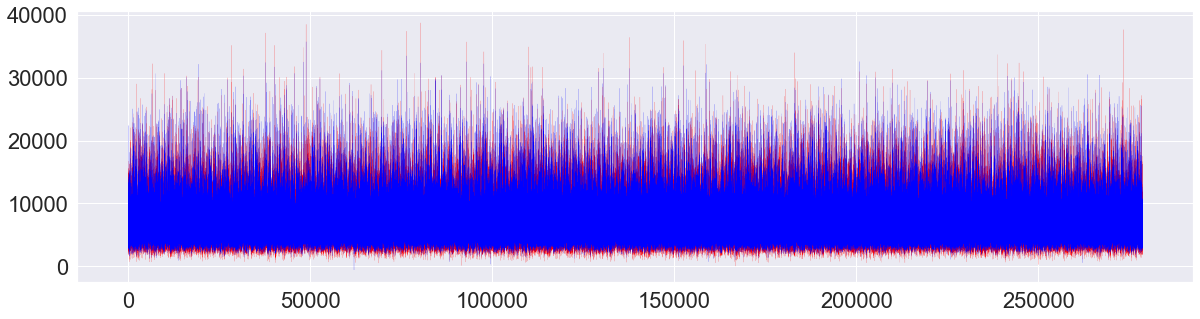

In [41]:
# Drop Sales and AvgPurchasing, but leave Customers
drop_sales_avg_df = no_Promo_Date.drop(['Sales', 'AvgPurchasing'], axis=1)

# Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(drop_sales_avg_df, target, test_size=0.33)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.figure(figsize=(20, 5))

plt.plot(y_test.values, color='red', linewidth=0.1)
plt.plot(y_pred, color='blue', linewidth=0.1)

In [42]:
drop_sales_avg_df.head()

,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
0,5,555,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
1,4,546,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
2,3,523,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
3,2,560,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
4,1,612,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0


In short, explain what the above plot and its specific trend.

###### Question 8

** Your answer: **







In [43]:
# The plot above shows the target values from the testing set (y_test) in red (i.e. the real observations)
# compared with the model's predictions (y_pred) in blue. If the predictions were completely accurate and 
# matched the real target observations, all of the red and blue would overlap in the plot. We can see
# that this is not the case, and given the R2 value of 0.76, we know that only 76% of the variability in Sales
# is explained by the model. However, that doesn't mean this is a good model. The model uses customer count as an
# input. This piece of information is highly correlated with sales but would not be available before a new 
# store opens; thus, it gives the model a false sense of accuracy.

#### Linear Regression: *ver. 2*

###### Question 9

R2 score: 0.92


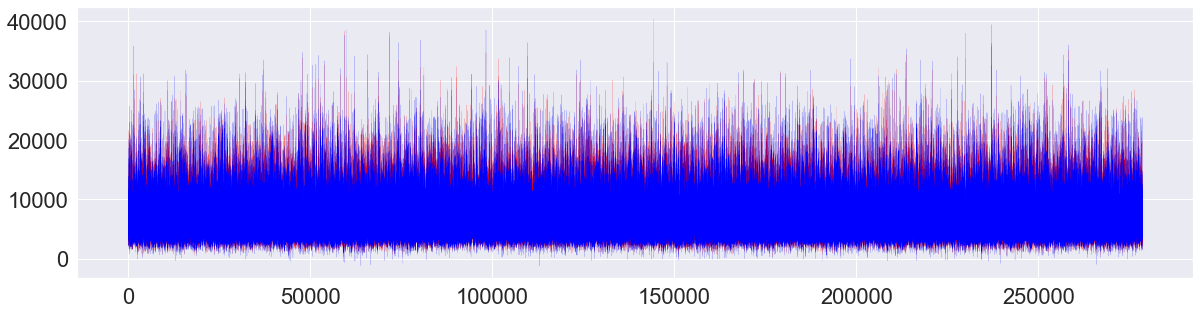

In [44]:
# YOUR CODE
# Drop Sales, but leave Customers and AvgPurchasing
# Elaborate about given R2 score

drop_sales_df = no_Promo_Date.drop(['Sales'], axis=1)

# Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(drop_sales_df, target, test_size=0.33)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.figure(figsize=(20, 5))

plt.plot(y_test.values, color='red', linewidth=0.1)
plt.plot(y_pred, color='blue', linewidth=0.1)


In [45]:
drop_sales_df.head()

,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,AvgPurchasing,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
0,5,555,1,1,0,1,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
1,4,546,1,1,0,1,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
2,3,523,1,1,0,1,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
3,2,560,1,1,0,1,8.948214,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
4,1,612,1,1,0,1,9.970588,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0


** Your answer: **

In [46]:
# This model appears stronger than the first, as evidenced by the R2 value closer to 1. The blue predictions match 
# the red observations in their reach toward the top of the plot, showing visually that the model does a good 
# job of capturing the variability in y_test. However, considering the input features, this model is even more
# useless. It takes in not only customer count but also average purchase amount per customer, a feature which is 
# engineered directly from that which we're trying to predict.

#### Linear Regression: *ver. 3*

R2 score: 0.20


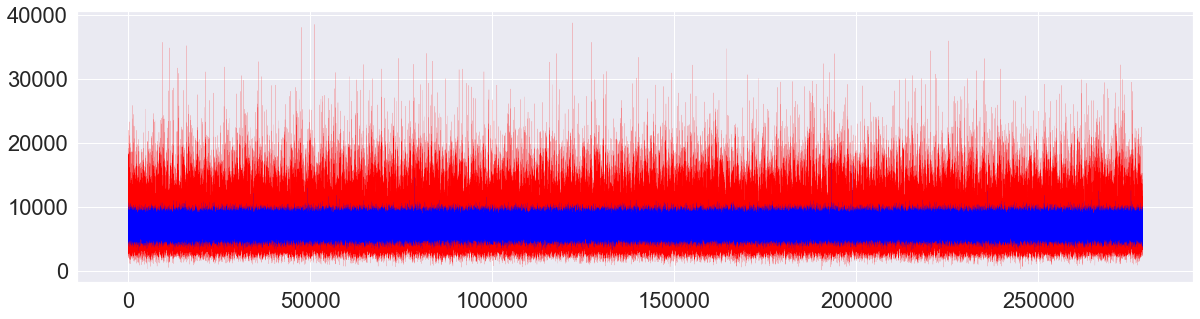

In [47]:
# Drop Sales and Customers
drop_sales_cust_df = no_Promo_Date.drop(['Sales', 'Customers'], axis=1)

# Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(drop_sales_cust_df, target, test_size=0.33)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.figure(figsize=(20, 5))

plt.plot(y_test.values, color='red', linewidth=0.1)
plt.plot(y_pred, color='blue', linewidth=0.1)

In [48]:
drop_sales_cust_df.head()

,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,AvgPurchasing,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
0,5,1,1,0,1,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
1,4,1,1,0,1,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
2,3,1,1,0,1,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
3,2,1,1,0,1,8.948214,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
4,1,1,1,0,1,9.970588,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0


###### Question 10

** Your answer: **

In [49]:
# This model is not good either. Its R2 value of 0.20 indicates that the model explains only 20% of 
# the variability in y_test. We can draw the same conclusion looking the plot, which shows plenty of red 
# (test observations) left uncovered by the blue predictions (i.e. unexplained by the model). Customer count has
# been dropped from the feauture set, which is a step in the right direction, but the model still uses
# average purchasing as a feature, which again, would not be available at the time of prediction.

### Tree Based Models

It has been well established that bagging and other resampling techniques can be used to reduce the variance in model predictions. As several replicates of the original data set are created using random selection with replacement, at every step, each derivative data set is then used to construct a new model and the models are gathered together into an ensemble. To make a prediction, all of the models in the ensemble are polled and their results are averaged in the case of regression, which is our specific approach.

As well, it has been well established that a powerful modeling algorithm that makes good use of bagging is Random Forests, which works by training numerous decision trees each based on a different resampling of the original training data. The random forest algorithm improves on bagging by training each tree on a random sample of the available features, to prevent each tree from choosing the same predictors.

In Random Forests the bias of the full model is equivalent to the bias of a single decision tree, which itself has high variance. By creating many of these trees, a forest, and then averaging them, the variance of the final model can be greatly reduced over that of a single tree. In practice the only limitation we encountered on the size of the forest is computing time, as an infinite number of trees could be trained without ever increasing bias and with a continual - if asymptotically declining - decrease in the variance.

It is for the aforementioned that we considered Random Forests as a Baseline Ensemble and its constituent, the Decision Tree Regressor as a baseline model as well.

### Decision Trees

Decision trees were implemented as to evaluate the base consituent of the Random Forest ensemble. As per our research on previous models, Random Forest is a very good performance candidate for a baseline ensemble model for Rossmann.

Decision Trees are also evaluated as a non-parametric baseline model, which enriches the comparative analysis of the Linear Regression Models.

For fitting the decision tree model, we do not need to create dummy variables for categorical columns, since trees are able to make use of the factorized category values we created during data cleaning.

### Random Forest

Next we considered Random Forest models. 

In [50]:
# Load libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Clean your data
clean_df = df_combined.drop(['Sales', 'Customers', 'AvgPurchasing', 'PromoInterval', 'Date'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(clean_df, target, test_size=0.33)

In [51]:
print(clean_df.shape)
clean_df.head()

(844338, 16)


,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
0,5,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
1,4,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
2,3,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
3,2,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
4,1,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0


In [52]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)

    best = gs.best_estimator_
    return best

#### Parameter Tuning via CV GridSearch

The paramters to be tuned are:

- max_depth
- n_estimartors
- max_features
- random_state

IMPORTANT: This might take a while!!!

In [76]:
# tuning n_estimators
parameters = {'max_depth': [8, 9, 10], # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
              'n_estimators': [10, 20, 30], # [ 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
              'max_features': [None], # [None, 'auto', 'sqrt', 'log2']
              'random_state': [10, 44], # [None, 10, 44, 100]
}
           
rf = RandomForestRegressor(max_depth=1, random_state=10)
optmized_rf_trees = cv_optimize(rf, parameters, X_train, y_train, n_jobs=-1, n_folds=5)

In [77]:
print('\nThe tuned parameters in the RF w/ customers, via CV grid search are:\n')
print('Max tree depth: {}\nNumber of Estimators: {}\nMax Features: {}\nRandom State: {}'.\
                                                                     format(optmized_rf_trees.max_depth,
                                                                     optmized_rf_trees.n_estimators,
                                                                     optmized_rf_trees.max_features,
                                                                     optmized_rf_trees.random_state))


The tuned parameters in the RF w/ customers, via CV grid search are:

Max tree depth: 10
Number of Estimators: 30
Max Features: None
Random State: 10


###### Question 11

R2 score: 0.55


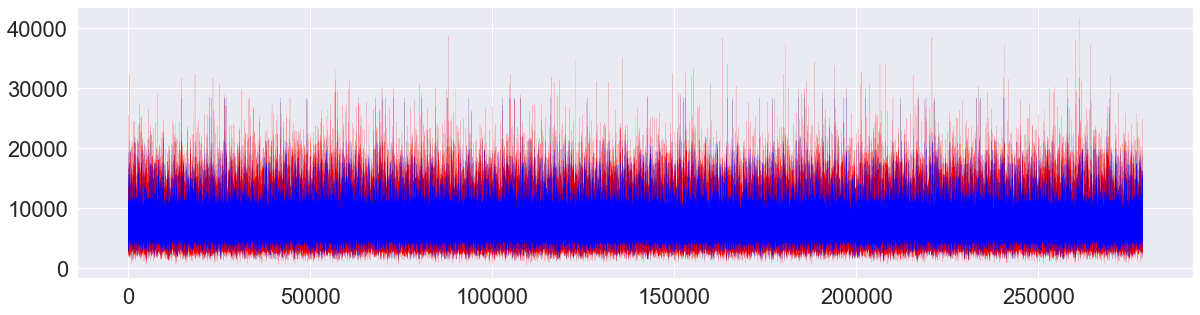

In [54]:
# YOUR CODE
# Run RandomForestRegressor with best params
# Elaborate about given R2 score

# Fit model on training data
rf = RandomForestRegressor(max_depth=10, n_estimators=30, random_state=10)
rf = rf.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = rf.predict(X_test)

# Explained variance score
print('R2 score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.figure(figsize=(20, 5))

plt.plot(y_test.values, color='red', linewidth=0.1)
plt.plot(y_pred, color='blue', linewidth=0.1)

###### Question 12

#### What is the best model? ** Your answer: **

In [ ]:
# The random forest is the best model. Even though it has an R2 value of 0.55, which is lower than the first two 
# models, the features are all logical inputs that would be available at the time of prediction.

## Export models 

In our final step, we will choose the best model and explore some important prediction elements. Our app accepts features and gives predictions based on users inputs. Let us see what kind of data input is neccessarry (this is important for you to setup the proper input on the Flask side). 

For example, take one simple observation (we are using first data row):

In [55]:
# Print first row
X_test.iloc[0]

DayOfWeek                               2.0
Open                                    1.0
Promo                                   1.0
StateHoliday                            0.0
SchoolHoliday                           0.0
StoreType                               1.0
Assortment                              1.0
CompetitionDistance                    40.0
CompetitionOpenSinceMonth               3.0
CompetitionOpenSinceYear             2014.0
Promo2                                  1.0
Promo2SinceWeek                         1.0
Promo2SinceYear                      2014.0
CompetitionOpenSinceMonth_missing       0.0
CompetitionOpenSinceYear_missing        0.0
CompetitionDistance_missing             0.0
Name: 742360, dtype: float64

Predict based on your first row:

In [56]:
# Test for your app
rf.predict(np.array(X_test.iloc[0].values.reshape(1, -1)))

array([10634.08594254])

Similar to the above line:

In [57]:
rf.predict(np.array([1, 1, 1, 0, 1, 1, 1, 290.0, 10.0, 2011.0, 1, 40.0, 2014.0, 0, 0, 0]).reshape(1, -1))

array([6223.55725499])

We can conclude that your input needs to be **numpy array**. Now, we can export pur model and get ready for the second part of the homework.

In [60]:
from sklearn.externals import joblib
joblib.dump(rf, 'rf.pkl')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['rf.pkl']

In [ ]:
# EXTRA CREDIT: ADDITIONAL MODELS

R2 score: 0.83


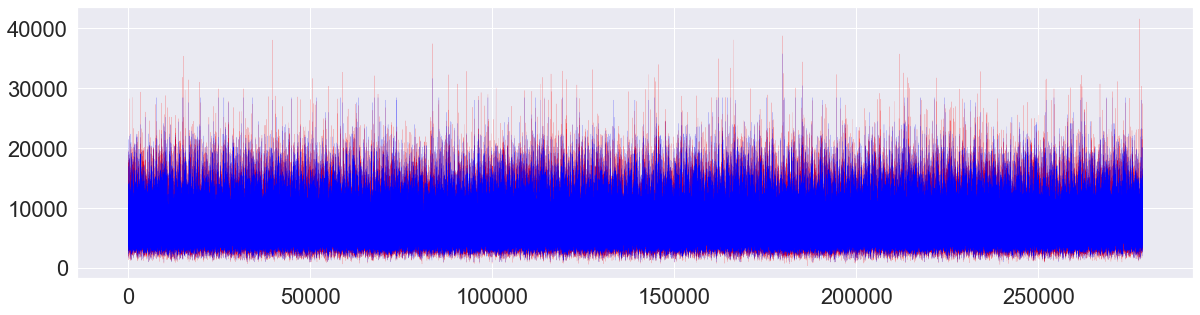

In [72]:
# Another random forest, max depth = 20

# Split observations between train and test
X_train, X_test, y_train, y_test = train_test_split(clean_df, target, test_size=0.33)

# Fit model on training data
rf2 = RandomForestRegressor(max_depth=20, n_estimators=30, random_state=10)
rf2 = rf2.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = rf2.predict(X_test)

# Explained variance score
print('R2 score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.figure(figsize=(20, 5))

plt.plot(y_test.values, color='red', linewidth=0.1)
plt.plot(y_pred, color='blue', linewidth=0.1)

In [ ]:
# The model above is the same as the previous random forest, but uses a max depth of 20 instead of 10. Model 
# performance is much stronger, as indicated by the R2 value of 0.83, but further analysis would be necessary 
# to ensure that this model is not overfit.

In [73]:
# pickle file for rf2
joblib.dump(rf2, 'rf2.pkl')

['rf2.pkl']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


R2 score: 0.83


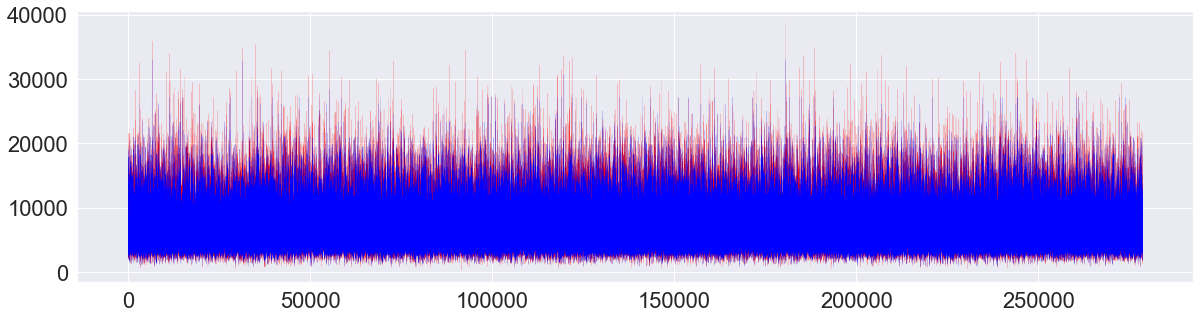

In [74]:
# XGBoost

from xgboost import XGBRegressor

# Split observations between train and test
X_train, X_test, y_train, y_test = train_test_split(clean_df, target, test_size=0.33)

# Fit model on training data
xg = XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 20, n_estimators = 30, random_state=10)
xg = xg.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = xg.predict(X_test)

# Explained variance score
print('R2 score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.figure(figsize=(20, 5))

plt.plot(y_test.values, color='red', linewidth=0.1)
plt.plot(y_pred, color='blue', linewidth=0.1)

In [75]:
# pickle file for xgboost
joblib.dump(xg, 'xg.pkl')

['xg.pkl']